# Orduz's verison of Hamiltonian Monte Carlo

In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import trange
import time

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
import  sklearn.preprocessing  # StandardScaler
from sklearn.ensemble import IsolationForest
import sklearn.model_selection #  train_test_split
import colossus
from colossus.cosmology import cosmology
# Set tensor numeric type.
dtype = 'float32'

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # to cycle through palette colors
if 1== 1 :
  sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
  )
sns.set_palette(palette='deep')
#sns.set_palette(palette="Paired_r")
#sns_c = sns.color_palette(palette="Paired_r")
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get TensorFlow version.
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))



2021-10-25 20:15:48.448228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/job/2.2.4-7.0.1.1_3.54__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2019.3.199/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2019.3.199/linux/mkl/lib/intel64:/usr/common/software/darshan/3.2.1/lib
2021-10-25 20:15:48.448248: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.8.0-dev20211012
TensorFlow Probability version: 0.15.0-dev20211013


2021-10-25 20:16:10.230778: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-25 20:16:10.243137: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-25 20:16:10.243160: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nid00573): /proc/driver/nvidia/version does not exist


In [2]:
cluster_data=pd.read_csv("~/Data/cluster_data_0.3-0.6-msm.csv")
clusters = pd.DataFrame( {"central_sm":cluster_data["central_sm"]} )
clusters["measured_sm"] = cluster_data["measured_sm"]
clusters["halo_mass"] = cluster_data["halo_mass"]
clusters.head()

,central_sm,measured_sm,halo_mass
0,12.115618,12.491581,14.658120
1,11.894872,12.111751,14.089678
2,11.763473,12.208368,14.383239
3,11.820660,12.358756,14.287383
4,11.628624,12.131789,14.141557


In [3]:
train,test = sklearn.model_selection.train_test_split(clusters, train_size=0.80)
X = train[train.columns[:-1]]
y = train[train.columns[-1]]
print("X, y:", X.shape, y.shape)
X_test = test[test.columns[:-1]]
y_test = test[test.columns[-1]]
all_X = clusters[clusters.columns[:-1]]
all_y = clusters[clusters.columns[-1]]

train = tf.data.Dataset.from_tensor_slices( (X, y)).shuffle(10000).batch(1000)

X=X.astype(dtype)
X_test=X_test.astype(dtype)
y=y.astype(dtype)
y_test=y_test.astype(dtype)
all_X = all_X.astype(dtype)
all_y = all_y.astype(dtype)

# Are these globals?
x = X
y = y

X, y: (229, 2) (229,)


In [4]:
#x = np.vstack([cluster_data[xname],cluster_data[x2name]]).transpose()
x = tf.convert_to_tensor(X, dtype=dtype)

y = tf.convert_to_tensor(y, dtype=dtype)
y = tf.reshape(y, (-1, 1))


print("x shape: {}, y shape: {}".format(x.shape,y.shape))

x shape: (229, 2), y shape: (229, 1)


In [5]:
jds_ab = tfd.JointDistributionNamedAutoBatched(dict(

    sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),

    alpha=tfd.Normal(
        #loc=[tf.cast(0.0, dtype)], 
        loc=[tf.cast(2.5, dtype)], 
        scale=[tf.cast(10.0, dtype)]
    ),

    beta=tfd.Normal(
        #loc=[[tf.cast(0.0, dtype)], [tf.cast(0.0, dtype)]], 
        loc=[[tf.cast(0.5, dtype)], [tf.cast(0.35, dtype)]],
        scale=[[tf.cast(10.0, dtype)], [tf.cast(10.0, dtype)]]
    ),

    y=lambda beta, alpha, sigma: 
        tfd.Normal(
            loc=tf.linalg.matmul(x, beta) + alpha, 
            scale=sigma
        ) 
))

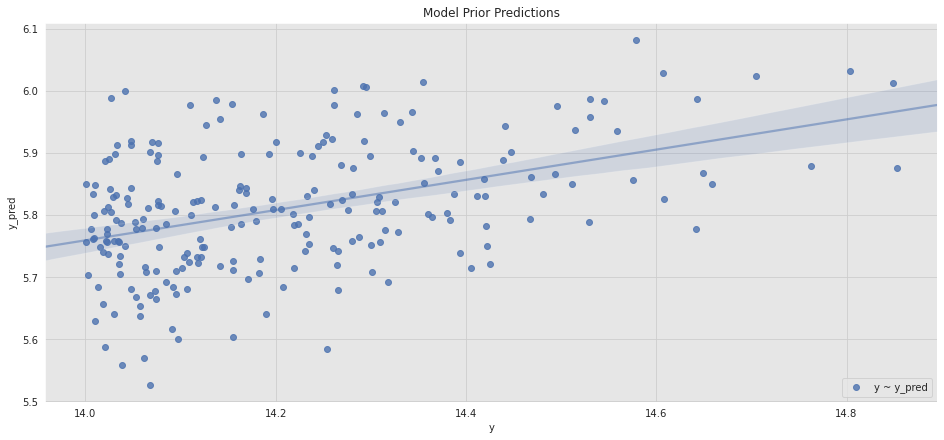

In [7]:
# Sample from the prior.
prior_samples = jds_ab.sample(500)['y']

prior_samples = tf.squeeze(prior_samples)
prior_mean = tf.math.reduce_mean(prior_samples, axis=0).numpy()
prior_std = tf.math.reduce_std(prior_samples, axis=0).numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6), constrained_layout=True)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    #scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
#print(tf.squeeze(y).numpy())
#print(prior_mean)
      
#ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Prior Predictions', xlabel='y', ylabel='y_pred');

In [8]:
#def target_log_prob_fn(beta=beta, alpha=alpha, sigma=sigma):
def target_log_prob_fn(beta, alpha, sigma):
    return jds_ab.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y)

# Size of each chain.
num_results = int(3e4)
# Burn-in steps.
#num_burnin_steps = int(2e5)
num_burnin_steps = int(1e4)


# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[1.0], [1.0]], dtype=dtype),
          tf.convert_to_tensor([1.0], dtype=dtype), 
          tf.convert_to_tensor([1.0], dtype=dtype)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [9]:
# Set number of chains. 
num_chains = 10
# Run sampling. 
chains = [run_chain() for i in trange(num_chains)]

print(len(chains[0][0]))

100%|██████████| 10/10 [07:21<00:00, 44.17s/it]

30000


     beta_0    beta_1     alpha     sigma  sample_id  chain_sample_id chain_id
0  0.542840  0.493682  1.814705  0.127217          0                0      c_1
1  0.542840  0.493682  1.814705  0.127217          1                1      c_1
2  0.542840  0.493682  1.814705  0.127217          2                2      c_1
3  0.543014  0.494603  1.811085  0.123533          3                3      c_1
4  0.543014  0.494603  1.811085  0.123533          4                4      c_1


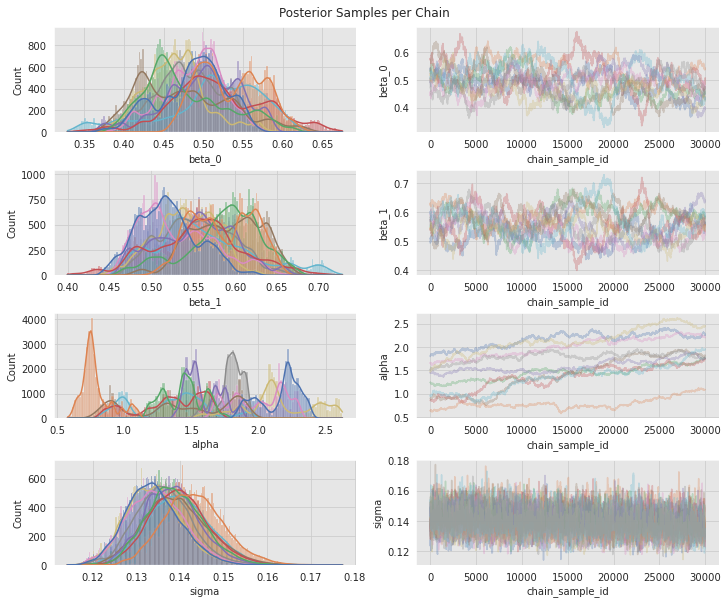

In [10]:
chains_t = list(map(list, zip(*chains)))

chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['beta_0', 'beta_1', 'alpha', 'sigma']
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % num_results,
        chain_id=lambda x: (x['sample_id'] / num_results).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

print(chains_df.head())

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    if num_chains < 6 :
        sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    else :
        sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0], legend=False)
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03);

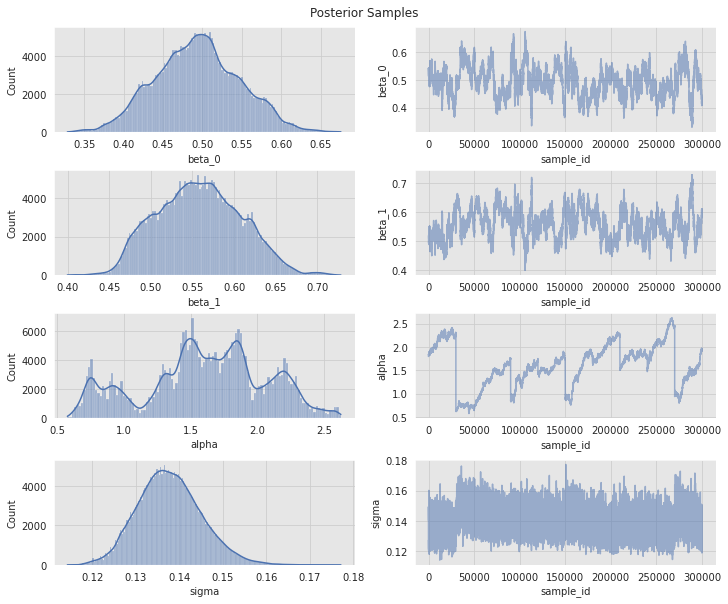

In [13]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, alpha=0.5, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03);

In [22]:
beta = [0.54, .4] 
alpha, sigma = 2.75, 0.104
beta = [0.57, .26] 
alpha, sigma = 4.2, 0.099
###
beta = [0.49, .55] 
alpha, sigma = 1.75, 0.138

### Generate Predictions

#### In-Sample

We want to see the model (in-sample) predictions. We begin by sampling from the distribution mean μ
(that is, we ignore σ).



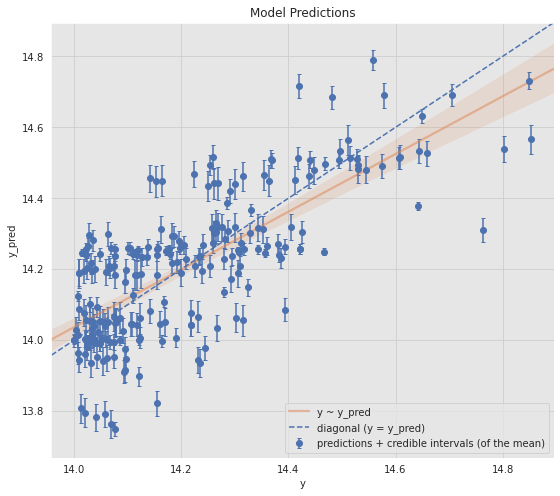

In [17]:
# Here we compute mu = alpha + beta x.
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x.shape[0]))) \
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x)) 

mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
    yerr=1*mu_posterior_std,
    fmt='o',
#    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals (of the mean)'
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
#    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Predictions', xlabel='y', ylabel='y_pred');

### Now let us generate (in-sample) predictions by sampling from N(μ,σ).

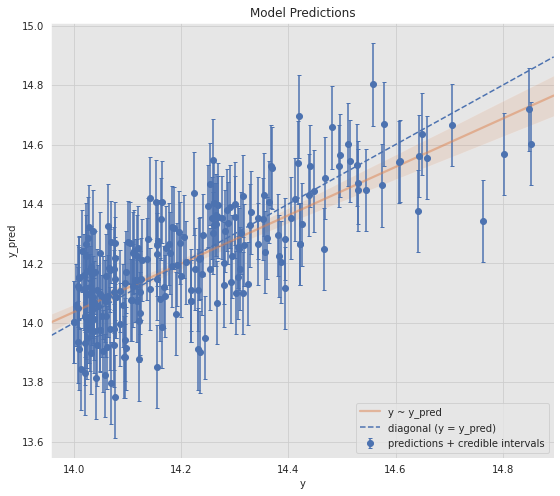

In [18]:
pred_samples = tf.map_fn(
    fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), 
    elems=tf.transpose(mu_posterior_samples)
)

pred_samples = tf.squeeze(pred_samples)

posterior_mean = tf.math.reduce_mean(pred_samples, axis=1).numpy()
posterior_std = tf.math.reduce_std(pred_samples, axis=1).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=posterior_mean, 
    yerr=1*posterior_std,
    fmt='o',
#    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals',
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
#    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--',  label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Predictions', xlabel='y', ylabel='y_pred');

#### Out-Sample

Finally let us generate an out-sample prediction for the vector x^* =(13,12.6).

Again, remember we are not interested in the point prediction but rather on the complete posterior distribution.

In [20]:
x_star = tf.cast([[13.0, 12.6]], dtype)
# Here we compute mu = alpha + beta x.
mu_y_star = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x_star.shape[0]))) \
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x_star)) 
# Compute posterior predictive distribution.
y_star_samples = tf.map_fn(
    fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), 
    elems=tf.transpose(mu_y_star)
)

In [23]:
#beta = [0.53, .32] # 
#alpha, sigma = 4., 0.12 # from a step in a chain
# now just after combined chains plot

# Point prediction of the mean.
y_star_true = tf.linalg.matmul(x_star, tf.transpose(tf.cast([beta], dtype))) + alpha
y_star_true  = y_star_true.numpy().flatten()
# Sample from the complete posterior predictive distribution.
y_star_true_samples =tfd.Normal(loc=y_star_true, scale=sigma).sample(num_chains * num_results)
y_star_true_samples = y_star_true_samples.numpy().flatten()
# Mean of the complete posterior predictive distribution.
y_star_true_samples_mean = tf.reduce_mean(y_star_samples, axis=2).numpy().flatten()

beta1: 0.49, beta2: 0.55, alpha: 1.75, sigma: 0.138


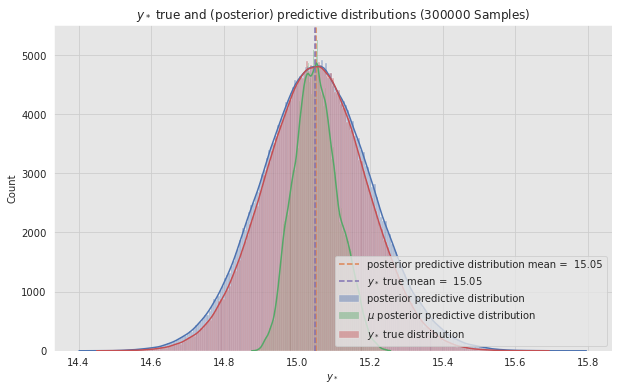

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
palette = itertools.cycle(sns.color_palette())
# color
c = next(palette)

sns.histplot(
    x=tf.squeeze(y_star_samples).numpy(), 
    kde=True, 
    color=c, 
    alpha=0.4,
    label='posterior predictive distribution', 
    ax=ax
)
c = next(palette)
ax.axvline(
    x=y_star_true_samples_mean, 
    color=c, 
    linestyle='--', 
    label=f'posterior predictive distribution mean = {y_star_true_samples_mean[0]: 0.2f}'
)
c = next(palette)
sns.histplot(
    x=mu_y_star.numpy().flatten(), 
    kde=True,
    color=c, 
    alpha=0.4,
    label='$\mu$ posterior predictive distribution', 
    ax=ax
)
c = next(palette)
sns.histplot(
    x=y_star_true_samples, 
    kde=True,
    color=c, 
    alpha=0.4,
    label='$y_*$ true distribution', 
    ax=ax
)
c = next(palette)
ax.axvline(
    x=y_star_true, 
    color=c, 
    linestyle='--', 
    label=f'$y_*$ true mean = {y_star_true[0]: 0.2f}'
)
#ax.legend(loc='lower left')
ax.legend(loc='lower right')
ax.set(
    title=f'$y_*$ true and (posterior) predictive distributions ({num_chains * num_results} Samples)',
    xlabel=f'$y_*$'
);

print("beta1: {}, beta2: {}, alpha: {}, sigma: {}".format(beta[0], beta[1], alpha, sigma))

- The red distribution is the “true” one which we get by sampling  from the N where parameters alpha, beta are "known"
- The purple distribution is the one of the mean posterior samples, and alpha,beta are samples from the posterior
- The pink distribution is the complete posterior predictive distribution

In [81]:
# for wide spread use
# ppd_df is the output of make_posterior_predictive_distribution
def yp_on_yt_plot (y_predictions, y_sigma, y_test, ppd_df) :
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), constrained_layout=True)

    ax[0].errorbar( x=np.array(y_test), y=y_predictions, yerr=y_sigma,fmt='o',
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals')
    sns.regplot(x=np.array(y_test), y=y_predictions,
        scatter=False, line_kws=dict(alpha=0.5), fit_reg=True, label="linear regression", 
        truncate=False, ax=ax[0])
    ax[0].plot(ppd_df["range"],ppd_df["mean"], color="black", label="y=x, 90% posterior predictive")
    ax[0].fill_between(ppd_df["range"], ppd_df["90l"], ppd_df["90u"], color='k', alpha=.1)
    ax[0].set(title='Model Predictions for Test Sample', xlabel='y',ylabel='y_pred');
    ax[0].legend(loc='lower right')
         
    ax[1].errorbar( x=np.array(y_test), y=y_predictions-np.array(y_test), yerr=y_sigma,fmt='o', 
        #ecolor=sns_c[1], mfc=sns_c[4],
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals',)
    sns.regplot(x=np.array(y_test), y = y_predictions-np.array(y_test),
        scatter=False, line_kws=dict(alpha=0.5),  fit_reg=True, label="linear regression",  
        truncate=False,  ax=ax[1])
    ax[1].plot(ppd_df["range"],np.zeros(ppd_df["mean"].size), 
               color="black", label="y=x, 90% posterior predictive")
    ax[1].fill_between(ppd_df["range"], ppd_df["90l"]-ppd_df["mean"], ppd_df["90u"]-ppd_df["mean"], color='k', alpha=.1)
    ax[1].set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
    ax[1].legend(loc='lower right')
    
def make_posterior_means_from_chains(chains_df, X_test, y_test , params, verbose=False) :
    x_star = tf.cast(tf.squeeze(X_test), dtype)
    
    alpha = chains_df["alpha"]
    sigma = chains_df["sigma"]
    beta_0 = chains_df["beta_0"]
    beta_1 = chains_df["beta_1"]
    beta = np.transpose(np.vstack([beta_0,beta_1]))
  
    if verbose: 
      print("X_test  ", X_test.shape)
      print("x_star  ", x_star.shape)
      print("alpha  ", alpha.shape)
      print("beta_0  ", beta_0.shape)
      print("beta_1  ", beta_1.shape)
      print("beta ",beta.shape)
      print("sigma  ", sigma.shape)
    # shapes_ch = alpha_ch.get_shape().as_list()
    # size = shapes_ch[0]*shapes_ch[1]

    # Here we compute mu = alpha + beta x.
    beta_x = tf.linalg.matmul(x_star, tf.transpose(beta) )
    if verbose: 
      print("beta_x  ", beta_x.shape)

    alpha = np.broadcast_to(alpha, (X_test.shape[0], alpha.size))    
    # compute mcmc posterior predictive distribution 
    mu_y_pred = alpha + beta_x
    if verbose: print("mu_y_star  ", mu_y_pred.shape)
    
    mu_posterior_mean = tf.math.reduce_mean(mu_y_pred, axis=1).numpy()
    mu_posterior_std = tf.math.reduce_std(mu_y_pred, axis=1).numpy()
    if verbose:print ("mu_posterior_mean  ",mu_posterior_mean.shape)

    # compute posterior predictive distribution from mu_posterior_mean and 
    # the chain computed sigma
    ppd_y_pred = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=sigma).sample(1), 
        elems=mu_posterior_mean    )
    ppd_y_pred = tf.squeeze(ppd_y_pred)
    if verbose: print("ppd_y_pred  ", ppd_y_pred.shape)

    posterior_mean = tf.math.reduce_mean(ppd_y_pred, axis=1).numpy()
    posterior_std = tf.math.reduce_std(ppd_y_pred, axis=1).numpy()
    if verbose: print ("posterior_mean  ",posterior_mean.shape)

    mu_chisq = (((mu_posterior_mean-y_test)/mu_posterior_std)**2).sum()/(y_test.size-len(params)-1)
    mu_rms = np.sqrt(((mu_posterior_mean-y_test)**2).sum()/y_test.size)
    chisq = (((posterior_mean-y_test)/posterior_std)**2).sum()/(y_test.size-len(params)-1)
    rms = np.sqrt(((posterior_mean-y_test)**2).sum()/y_test.size)

    print("\n Test data\n")
    print ("mu_posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(mu_chisq,mu_rms))
    print ("   posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

    # prepare the fit and confidence interval: weirdly, assuming that the only thing that matters is sigma
    # becuse it is a posterior predictive distribution 
    ppd_df = make_posterior_predictive_distribution (tf.math.reduce_mean(sigma))

    answers={}
    answers["mu_posterior_mean"] = mu_posterior_mean
    answers["mu_posterior_std"] = mu_posterior_std
    answers["mu_posterior_dist"] = mu_y_pred
    answers["posterior_mean"] = posterior_mean
    answers["posterior_std"] = posterior_std
    answers["posterior_dist"] = ppd_y_pred
    answers["ppd_df"] = ppd_df

    return answers

def make_posterior_predictive_distribution (sigma, verbose=False) :
    # prepare the fit and confidence interval: weirdly, assuming that the only thing that matters is sigma
    # becuse it is a posterior predictive distribution 
    range_x = np.arange(14.0,15.0,0.05) ; 
    if verbose : print("range_x: ", range_x.shape)
    range_y = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=sigma).sample(20000), 
        elems=tf.constant(range_x , dtype=dtype )  )
    range_y = tf.squeeze(range_y)
    if verbose: print("range_y  ", range_y.shape)

    range_mean = tf.math.reduce_mean(range_y, axis=1).numpy()
    range_std = tf.math.reduce_std(range_y, axis=1).numpy()
    range_90l = range_mean - 2*range_std
    range_90u = range_mean + 2*range_std
    df = pd.DataFrame({"mean": range_mean})
    df["range"]= range_x
    df["std"]= range_std
    df["90l"]= range_90l
    df["90u"]= range_90u
    return df
#

     beta_0    beta_1     alpha     sigma  sample_id  chain_sample_id chain_id
0  0.542840  0.493682  1.814705  0.127217          0                0      c_1
1  0.542840  0.493682  1.814705  0.127217          1                1      c_1
2  0.542840  0.493682  1.814705  0.127217          2                2      c_1
3  0.543014  0.494603  1.811085  0.123533          3                3      c_1
4  0.543014  0.494603  1.811085  0.123533          4                4      c_1

 Test data

mu_posterior_std  chi-sq and rms: 160.02  0.152
   posterior_std  chi-sq and rms:   1.33  0.152


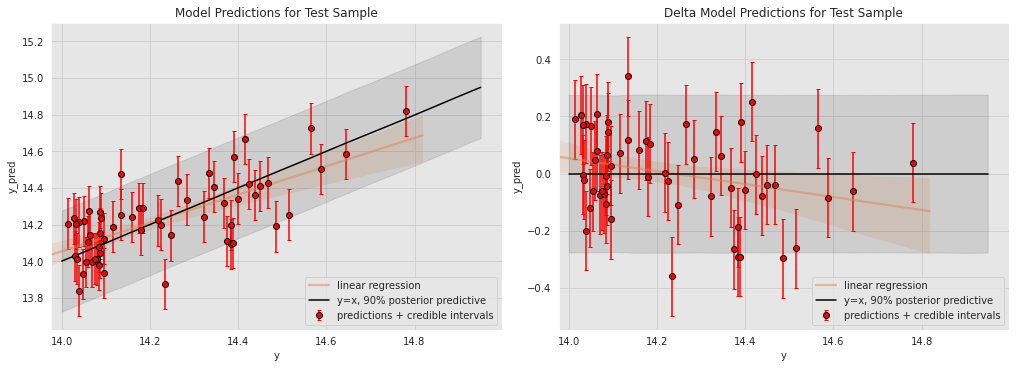

In [82]:
print(chains_df.head())
#print(chains_df["alpha"])
answers = make_posterior_means_from_chains(chains_df, X_test, y_test, params, verbose=False)    
yp_on_yt_plot (answers["posterior_mean"], answers["posterior_std"], y_test, answers["ppd_df"])
#

X_test   (287, 2)
x_star   (287, 2)
alpha   (300000,)
beta_0   (300000,)
beta_1   (300000,)
beta  (300000, 2)
sigma   (300000,)
beta_x   (287, 300000)
mu_y_star   (287, 300000)
mu_posterior_mean   (287,)
ppd_y_pred   (287, 300000)
posterior_mean   (287,)

 Test data

mu_posterior_std  chi-sq and rms: 115.77  0.140
   posterior_std  chi-sq and rms:   1.04  0.140


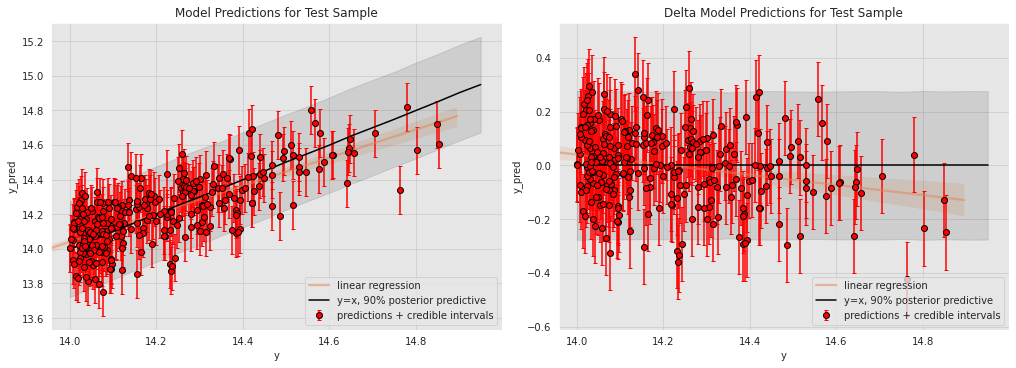

In [83]:
answers = make_posterior_means_from_chains(chains_df, all_X, all_y, params, verbose=False)    
yp_on_yt_plot (answers["posterior_mean"], answers["posterior_std"], all_y, answers["ppd_df"])
#